# HiGAN+ Handwriting Generation Model

This notebook implements the HiGAN+ (Hierarchical Generative Adversarial Network) model for handwriting generation from scratch. The model includes:
- **Generator**: Generates handwritten text images from style vectors and text content
- **Discriminator**: Global and patch-based discriminators for realistic image generation
- **Style Encoder**: Extracts style information from reference handwriting
- **OCR Network**: Ensures generated text is readable
- **Writer Identifier**: Preserves writer-specific characteristics

## Architecture Overview
- **Training Phase**: Train the GAN model with multiple loss functions
- **Evaluation Phase**: Calculate FID, KID, IS, CER, WER metrics
- **Inference Phase**: Generate new handwriting samples

## 1. Import Libraries and Setup

In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import h5py
import cv2
from datetime import datetime

## Jugad pro
# Fix for Pillow>=10 where Image.ANTIALIAS moved under Image.Resampling
if not hasattr(Image, "ANTIALIAS"):
    Image.ANTIALIAS = Image.Resampling.LANCZOS

# Add project paths
project_path = r'B:\\College\\DL\\Higan+ from Scratch'
sys.path.insert(0, project_path)

# Import HiGAN+ modules
from lib.datasets import get_dataset, get_collect_fn, Hdf5Dataset
from lib.alphabet import strLabelConverter, Alphabets
from lib.utils import yaml2config, draw_image, AverageMeter
from networks import get_model
from networks.BigGAN_networks import Generator, Discriminator, PatchDiscriminator
from networks.module import Recognizer, WriterIdentifier, StyleEncoder, StyleBackbone
from torch.utils.data import DataLoader

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

C:\Users\PC\AppData\Local\Temp\ipykernel_49988\1421141724.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  if not hasattr(Image, "ANTIALIAS"):


PyTorch version: 2.8.0+cu129
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU

Using device: cuda


## 2. Load Configuration and Dataset

In [2]:
# Load configuration
config_path = os.path.join(project_path, 'configs', 'gan_iam.yml')
cfg = yaml2config(config_path)

# Override some config settings for notebook
cfg.device = str(device)
cfg.training.batch_size = 4  # Smaller batch for notebook
cfg.training.epochs = 5  # Fewer epochs for demo
cfg.training.print_iter_val = 10
cfg.training.sample_iter_val = 50

print("Configuration loaded!")
print(f"Dataset: {cfg.dataset}")
print(f"Model: {cfg.model}")
print(f"Batch size: {cfg.training.batch_size}")
print(f"Epochs: {cfg.training.epochs}")
print(f"Image height: {cfg.img_height}")
print(f"Character width: {cfg.char_width}")

Configuration loaded!
Dataset: iam_word_org
Model: gl_adversarial_model
Batch size: 4
Epochs: 5
Image height: 64
Character width: 32


In [3]:
import os

print("Current working directory:", os.getcwd())


Current working directory: b:\College\DL\Higan+ from Scratch


In [4]:
# Create dataset and dataloader
print("\nLoading dataset...")

collect_fn = get_collect_fn(cfg.training.sort_input, sort_style=True)
try:
    train_dataset = get_dataset(
        cfg.dataset, 
        cfg.training.dset_split,
        recogn_aug=True, 
        wid_aug=True, 
        process_style=True
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.training.batch_size,
        shuffle=True,
        collate_fn=collect_fn,
        num_workers=0,  # Set to 0 for notebook
        drop_last=True
    )
    
    test_dataset = get_dataset(
        cfg.valid.dset_name,
        cfg.valid.dset_split,
        recogn_aug=False,
        wid_aug=False,
        process_style=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=cfg.training.eval_batch_size // 2,
        shuffle=True,
        collate_fn=collect_fn,
        num_workers=0
    )
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}")
    
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("\nNote: Make sure the IAM dataset HDF5 files are in the correct location:")
    print("  - b:\\College\\DL\\Higan+ from Scratch\\iam\\trnvalset_words64_OrgSz.hdf5")
    print("  - b:\\College\\DL\\Higan+ from Scratch\\iam\\testset_words64_OrgSz.hdf5")


Loading dataset...
Training samples: 52231
Test samples: 11170
Training batches: 13057
Training samples: 52231
Test samples: 11170
Training batches: 13057


## 3. Visualize Sample Data

In [5]:
import PIL
print(PIL.__version__)

9.5.0


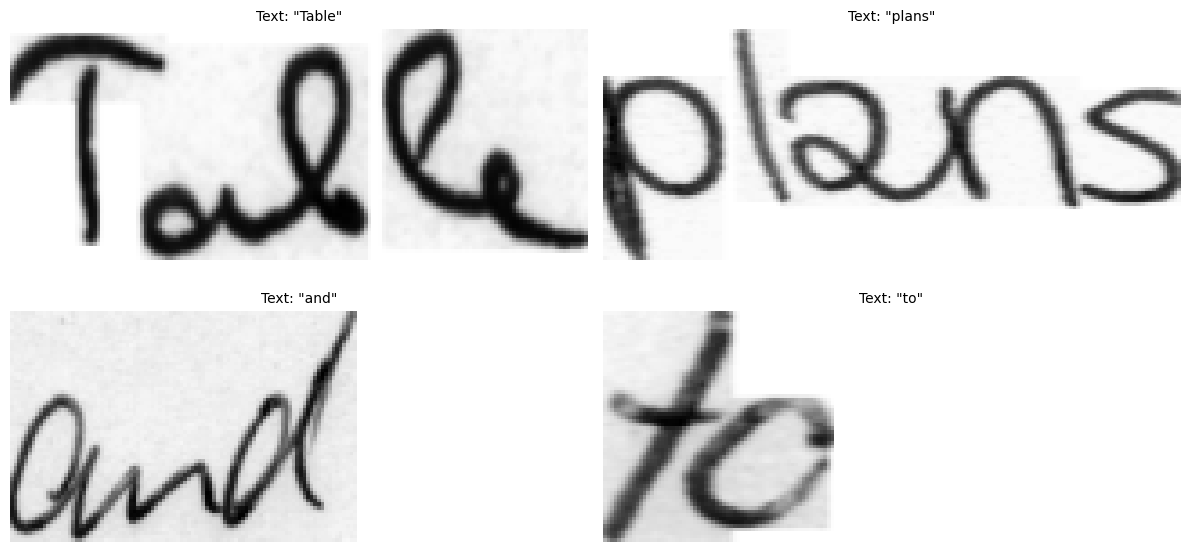


Batch shape: torch.Size([4, 1, 64, 160])
Label shape: torch.Size([4, 5])
Sample texts: ['Table', 'plans', 'and', 'to']


In [6]:
# Visualize some training samples
try:
    sample_batch = next(iter(train_loader))
    
    label_converter = strLabelConverter('all')
    
    # Get images and labels
    imgs = sample_batch['style_imgs']
    lbs = sample_batch['lbs']
    lb_lens = sample_batch['lb_lens']
    
    # Decode labels
    texts = label_converter.decode(lbs, lb_lens)
    
    # Plot samples
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(min(4, imgs.size(0))):
        img = imgs[i].squeeze().numpy()
        # Convert from [-1, 1] to [0, 1] for display
        img = (1 - img) / 2
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Text: "{texts[i]}"', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBatch shape: {imgs.shape}")
    print(f"Label shape: {lbs.shape}")
    print(f"Sample texts: {texts[:4]}")
    
except Exception as e:
    print(f"Could not visualize samples: {e}")

## 4. Initialize HiGAN+ Model

In [7]:
print("Initializing HiGAN+ model components...")

# Initialize Generator
generator = Generator(**cfg.GenModel).to(device)
print(f"✓ Generator initialized - Style dim: {generator.style_dim}")

# Initialize Discriminators
discriminator = Discriminator(**cfg.DiscModel).to(device)
patch_discriminator = PatchDiscriminator(**cfg.PatchDiscModel).to(device)
print(f"✓ Discriminators initialized (Global + Patch)")

# Initialize Style Encoder & Backbone
style_backbone = StyleBackbone(**cfg.StyBackbone).to(device)
style_encoder = StyleEncoder(**cfg.EncModel).to(device)
print(f"✓ Style Encoder initialized")

# Initialize Recognizer (OCR)
recognizer = Recognizer(**cfg.OcrModel).to(device)
print(f"✓ OCR Recognizer initialized")

# Initialize Writer Identifier
writer_identifier = WriterIdentifier(**cfg.WidModel).to(device)
print(f"✓ Writer Identifier initialized")

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n--- Model Parameters ---")
print(f"Generator: {count_parameters(generator):,}")
print(f"Discriminator: {count_parameters(discriminator):,}")
print(f"Patch Discriminator: {count_parameters(patch_discriminator):,}")
print(f"Style Encoder: {count_parameters(style_encoder):,}")
print(f"Style Backbone: {count_parameters(style_backbone):,}")
print(f"Recognizer: {count_parameters(recognizer):,}")
print(f"Writer ID: {count_parameters(writer_identifier):,}")
print(f"\nTotal Parameters: {count_parameters(generator) + count_parameters(discriminator) + count_parameters(patch_discriminator) + count_parameters(style_encoder) + count_parameters(style_backbone) + count_parameters(recognizer) + count_parameters(writer_identifier):,}")

Initializing HiGAN+ model components...
✓ Generator initialized - Style dim: 32
✓ Discriminators initialized (Global + Patch)
✓ Style Encoder initialized
✓ OCR Recognizer initialized
✓ Writer Identifier initialized

--- Model Parameters ---
Generator: 3,935,937
Discriminator: 2,366,145
Patch Discriminator: 2,366,145
Style Encoder: 148,032
Style Backbone: 1,617,328
Recognizer: 2,428,416
Writer ID: 161,396

Total Parameters: 13,023,399
✓ Style Encoder initialized
✓ OCR Recognizer initialized
✓ Writer Identifier initialized

--- Model Parameters ---
Generator: 3,935,937
Discriminator: 2,366,145
Patch Discriminator: 2,366,145
Style Encoder: 148,032
Style Backbone: 1,617,328
Recognizer: 2,428,416
Writer ID: 161,396

Total Parameters: 13,023,399


In [8]:
# Load pretrained OCR and Writer ID models (if available)
print("\nLoading pretrained auxiliary models...")

try:
    # Load pretrained OCR
    if os.path.exists(cfg.training.pretrained_r):
        r_dict = torch.load(cfg.training.pretrained_r, map_location=device)
        recognizer.load_state_dict(r_dict['Recognizer'])
        print(f"✓ Loaded pretrained OCR from {cfg.training.pretrained_r}")
    else:
        print(f"⚠ Pretrained OCR not found: {cfg.training.pretrained_r}")
    
    # Load pretrained Writer ID
    if os.path.exists(cfg.training.pretrained_w):
        w_dict = torch.load(cfg.training.pretrained_w, map_location=device)
        writer_identifier.load_state_dict(w_dict['WriterIdentifier'])
        style_backbone.load_state_dict(w_dict['StyleBackbone'])
        print(f"✓ Loaded pretrained Writer ID from {cfg.training.pretrained_w}")
    else:
        print(f"⚠ Pretrained Writer ID not found: {cfg.training.pretrained_w}")
        
except Exception as e:
    print(f"⚠ Error loading pretrained models: {e}")
    print("Continuing with randomly initialized models...")

# Freeze OCR and Writer ID networks during GAN training
for param in recognizer.parameters():
    param.requires_grad = False
for param in writer_identifier.parameters():
    param.requires_grad = False
    
print("\n✓ OCR and Writer ID networks frozen for GAN training")


Loading pretrained auxiliary models...
✓ Loaded pretrained OCR from ./pretrained/ocr_iam_new.pth
✓ Loaded pretrained Writer ID from ./pretrained/wid_iam_new.pth

✓ OCR and Writer ID networks frozen for GAN training
✓ Loaded pretrained Writer ID from ./pretrained/wid_iam_new.pth

✓ OCR and Writer ID networks frozen for GAN training


## 5. Setup Training Components

In [10]:
from itertools import chain
from torch.nn import CTCLoss, CrossEntropyLoss
from networks.loss import recn_l1_loss, CXLoss, KLloss
from networks.rand_dist import prepare_z_dist, prepare_y_dist
from networks.utils import get_scheduler, idx_to_words, set_requires_grad

print("Setting up optimizers and loss functions...")

# Optimizers
optimizer_G = torch.optim.Adam(
    chain(generator.parameters(), style_encoder.parameters()),
    lr=cfg.training.lr,
    betas=(cfg.training.adam_b1, cfg.training.adam_b2)
 )

optimizer_D = torch.optim.Adam(
    chain(discriminator.parameters(), patch_discriminator.parameters()),
    lr=cfg.training.lr,
    betas=(cfg.training.adam_b1, cfg.training.adam_b2)
 )

print(f"✓ Optimizers initialized (lr={cfg.training.lr})")

# Learning rate schedulers
lr_scheduler_G = get_scheduler(optimizer_G, cfg.training)
lr_scheduler_D = get_scheduler(optimizer_D, cfg.training)
print(f"✓ LR Schedulers initialized ({cfg.training.lr_policy})")

# Loss functions
ctc_loss = CTCLoss(zero_infinity=True, reduction='mean')
classify_loss = CrossEntropyLoss()
contextual_loss = CXLoss()
print(f"✓ Loss functions initialized")

# Load lexicon for text generation
from lib.alphabet import get_lexicon, get_true_alphabet

lexicon = get_lexicon(
    cfg.training.lexicon,
    get_true_alphabet(cfg.dataset),
    max_length=cfg.training.max_word_len
)
if not lexicon:
    print(f"⚠ Lexicon file missing or empty at {cfg.training.lexicon}. Building fallback from dataset...")
    alphabet = get_true_alphabet(cfg.dataset)
    dataset_words = set()
    for start_idx, length in zip(train_dataset.lb_seek_idxs, train_dataset.lb_lens):
        length = int(length)
        if length <= 1 or length >= cfg.training.max_word_len:
            continue
        raw_word = ''.join(chr(ch) for ch in train_dataset.lbs[start_idx:start_idx + length])
        filtered_word = ''.join(ch for ch in raw_word if ch in alphabet)
        if len(filtered_word) <= 1:
            continue
        dataset_words.add(filtered_word.lower())
    lexicon = sorted(dataset_words)
    if not lexicon:
        raise RuntimeError("Unable to build fallback lexicon. Provide a valid lexicon file with at least one entry.")
    print(f"✓ Fallback lexicon built from dataset: {len(lexicon)} words")
else:
    print(f"✓ Lexicon loaded: {len(lexicon)} words")

# Initialize random distributions for sampling
z_dist = prepare_z_dist(cfg.training.batch_size, cfg.EncModel.style_dim, device, seed=cfg.seed)
y_dist = prepare_y_dist(cfg.training.batch_size, len(lexicon), device, seed=cfg.seed)
print(f"✓ Random distributions initialized")

print("\n✓ Training setup complete!")

Setting up optimizers and loss functions...
✓ Optimizers initialized (lr=0.0002)
✓ LR Schedulers initialized (linear)
✓ Loss functions initialized
✓ Lexicon loaded: 465593 words
✓ Random distributions initialized

✓ Training setup complete!
✓ Lexicon loaded: 465593 words
✓ Random distributions initialized

✓ Training setup complete!


## 6. Training Loop

Now we'll train the HiGAN+ model with:
- **Adversarial Loss**: Makes generated images realistic
- **CTC Loss**: Ensures text readability
- **Writer ID Loss**: Preserves writing style
- **Reconstruction Loss**: Improves content fidelity
- **Contextual Loss**: Matches texture/style features
- **KL Loss**: Regularizes latent space (VAE mode)

In [11]:
from networks.utils import extract_all_patches

# Training history
history = {
    'epoch': [],
    'g_loss': [],
    'd_loss': [],
    'adv_loss': [],
    'ctc_loss': [],
    'wid_loss': [],
    'recn_loss': []
}

# Helper function for model mode setting
def set_model_mode(mode='train'):
    models = [generator, discriminator, patch_discriminator, 
              style_encoder, style_backbone]
    for model in models:
        if mode == 'train':
            model.train()
        else:
            model.eval()

print("Starting training...")
print(f"Training for {cfg.training.epochs} epochs")
print(f"Batch size: {cfg.training.batch_size}")
print("-" * 60)

Starting training...
Training for 5 epochs
Batch size: 4
------------------------------------------------------------


In [12]:
# Main training loop
vae_mode = cfg.training.vae_mode
ctc_len_scale = recognizer.len_scale
label_converter = strLabelConverter('all')

iter_count = 0
num_epochs = cfg.training.epochs

for epoch in range(1, num_epochs + 1):
    set_model_mode('train')
    
    # Accumulators for metrics
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    epoch_adv_loss = 0.0
    epoch_ctc_loss = 0.0
    epoch_wid_loss = 0.0
    epoch_recn_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}')
    
    for batch_idx, batch in enumerate(pbar):
        try:
            # Move data to device
            real_imgs = batch['style_imgs'].to(device)
            real_img_lens = batch['style_img_lens'].to(device)
            real_aug_imgs = batch['aug_imgs'].to(device)
            real_aug_img_lens = batch['aug_img_lens'].to(device)
            real_lbs = batch['lbs'].to(device)
            real_lb_lens = batch['lb_lens'].to(device)
            real_wids = batch['wids'].to(device)
            
            max_label_len = real_lbs.size(-1)
            
            # =============================
            # Train Discriminator
            # =============================
            optimizer_D.zero_grad()
            set_requires_grad([generator, style_encoder], False)
            set_requires_grad([discriminator, patch_discriminator], True)
            
            with torch.no_grad():
                # Sample random texts
                y_dist.sample_()
                sampled_words = idx_to_words(y_dist, lexicon, max_label_len,
                                            cfg.training.capitalize_ratio,
                                            cfg.training.blank_ratio)
                fake_lbs, fake_lb_lens = label_converter.encode(sampled_words, max_label_len)
                fake_lbs = fake_lbs.to(device)
                fake_lb_lens = fake_lb_lens.to(device)
                
                # Sample style vectors
                z_dist.sample_()
                fake_imgs = generator(z_dist, fake_lbs, fake_lb_lens)
                
                # Encode real images
                if vae_mode:
                    enc_z, _, _ = style_encoder(real_imgs, real_img_lens, style_backbone, vae_mode=True)
                else:
                    enc_z = style_encoder(real_imgs, real_img_lens, style_backbone, vae_mode=False)
                
                style_imgs = generator(enc_z, fake_lbs, fake_lb_lens)
                recn_imgs = generator(enc_z, real_lbs, real_lb_lens)
                
                cat_fake_imgs = torch.cat([fake_imgs, style_imgs, recn_imgs], dim=0)
                cat_fake_lb_lens = torch.cat([fake_lb_lens, fake_lb_lens, real_lb_lens], dim=0)
                cat_fake_img_lens = cat_fake_lb_lens * cfg.char_width
            
            # Discriminate fake images
            fake_disc = discriminator(cat_fake_imgs.detach(), cat_fake_img_lens, cat_fake_lb_lens)
            fake_disc_loss = torch.mean(F.relu(1.0 + fake_disc))
            
            fake_img_patches = extract_all_patches(cat_fake_imgs, cat_fake_img_lens)
            fake_disc_patches = patch_discriminator(fake_img_patches.detach())
            fake_disc_loss_patch = torch.mean(F.relu(1.0 + fake_disc_patches))
            
            # Discriminate real images
            real_disc = discriminator(real_imgs, real_img_lens, real_lb_lens)
            real_disc_aug = discriminator(real_aug_imgs, real_aug_img_lens, real_lb_lens)
            real_disc_loss = (torch.mean(F.relu(1.0 - real_disc)) +
                             torch.mean(F.relu(1.0 - real_disc_aug))) / 2
            
            real_img_patches = extract_all_patches(real_imgs, real_img_lens)
            real_aug_imgs_patches = extract_all_patches(real_aug_imgs, real_aug_img_lens)
            real_disc_patches = patch_discriminator(torch.cat([real_img_patches, real_aug_imgs_patches], dim=0))
            real_disc_loss_patch = torch.mean(F.relu(1.0 - real_disc_patches))
            
            d_loss = real_disc_loss + fake_disc_loss + real_disc_loss_patch + fake_disc_loss_patch
            d_loss.backward()
            optimizer_D.step()
            
            # =============================
            # Train Generator
            # =============================
            if iter_count % cfg.training.num_critic_train == 0:
                optimizer_G.zero_grad()
                set_requires_grad([discriminator, patch_discriminator], False)
                set_requires_grad([generator, style_encoder], True)
                
                # Generate fake samples
                y_dist.sample_()
                sampled_words = idx_to_words(y_dist, lexicon, max_label_len,
                                            cfg.training.capitalize_ratio,
                                            cfg.training.blank_ratio, sort=True)
                fake_lbs, fake_lb_lens = label_converter.encode(sampled_words, max_label_len)
                fake_lbs = fake_lbs.to(device)
                fake_lb_lens = fake_lb_lens.to(device)
                
                z_dist.sample_()
                fake_imgs = generator(z_dist, fake_lbs, fake_lb_lens)
                
                # Encode and generate
                if vae_mode:
                    (enc_z, mu, logvar), real_img_feats = style_encoder(real_imgs, real_img_lens, 
                                                                         style_backbone, ret_feats=True, vae_mode=True)
                else:
                    enc_z, real_img_feats = style_encoder(real_imgs, real_img_lens, 
                                                          style_backbone, ret_feats=True, vae_mode=False)
                
                style_imgs = generator(enc_z, fake_lbs, fake_lb_lens)
                recn_imgs = generator(enc_z, real_lbs, real_lb_lens)
                
                # Adversarial loss
                cat_fake_imgs = torch.cat([fake_imgs, style_imgs, recn_imgs], dim=0)
                cat_fake_lb_lens = torch.cat([fake_lb_lens, fake_lb_lens, real_lb_lens], dim=0)
                cat_fake_disc = discriminator(cat_fake_imgs, cat_fake_lb_lens * cfg.char_width, cat_fake_lb_lens)
                adv_loss = -torch.mean(cat_fake_disc)
                
                fake_img_patches = extract_all_patches(cat_fake_imgs, cat_fake_lb_lens * cfg.char_width)
                fake_disc_patches = patch_discriminator(fake_img_patches)
                adv_loss_patch = -torch.mean(fake_disc_patches)
                
                # CTC loss
                fake_img_lens = fake_lb_lens * cfg.char_width
                fake_ctc_rand = recognizer(fake_imgs, fake_img_lens)
                fake_ctc_loss_rand = ctc_loss(fake_ctc_rand, fake_lbs, 
                                              fake_img_lens // ctc_len_scale, fake_lb_lens)
                
                style_img_lens = fake_lb_lens * cfg.char_width
                fake_ctc_style = recognizer(style_imgs, style_img_lens)
                fake_ctc_loss_style = ctc_loss(fake_ctc_style, fake_lbs,
                                               style_img_lens // ctc_len_scale, fake_lb_lens)
                
                recn_img_lens = real_lb_lens * cfg.char_width
                fake_ctc_recn = recognizer(recn_imgs, recn_img_lens)
                fake_ctc_loss_recn = ctc_loss(fake_ctc_recn, real_lbs,
                                              recn_img_lens // ctc_len_scale, real_lb_lens)
                
                fake_ctc_loss_total = fake_ctc_loss_rand + fake_ctc_loss_recn + fake_ctc_loss_style
                
                # Style reconstruction loss
                styles = style_encoder(fake_imgs, fake_lb_lens * cfg.char_width, style_backbone)
                info_loss = torch.mean(torch.abs(styles - z_dist.detach()))
                
                # Content reconstruction loss
                recn_loss_val = recn_l1_loss(recn_imgs, real_imgs, real_img_lens)
                
                # Writer ID loss
                cat_style_imgs = torch.cat([style_imgs, recn_imgs], dim=0)
                cat_style_img_lens = torch.cat([fake_lb_lens, real_lb_lens], dim=0) * cfg.char_width
                recn_wid_logits, fake_imgs_feats = writer_identifier(cat_style_imgs, cat_style_img_lens,
                                                                     style_backbone, ret_feats=True)
                fake_wid_loss = classify_loss(recn_wid_logits, real_wids.repeat(2))
                
                # Contextual loss
                ctx_loss_val = torch.FloatTensor([0.]).to(device)
                for real_img_feat, fake_img_feat in zip(real_img_feats, fake_imgs_feats):
                    fake_feat = fake_img_feat.chunk(2, dim=0)
                    ctx_loss_val += contextual_loss(real_img_feat, fake_feat[0])
                    ctx_loss_val += contextual_loss(real_img_feat, fake_feat[1])
                
                # KL loss
                kl_loss_val = KLloss(mu, logvar) if vae_mode else torch.FloatTensor([0.]).to(device)
                
                # Gradient penalty (simplified)
                gp_ctc = 1.0
                gp_info = 1.0
                gp_wid = 1.0
                gp_recn = 1.0
                
                # Total generator loss
                g_loss = (adv_loss + adv_loss_patch +
                         gp_ctc * fake_ctc_loss_total +
                         gp_info * info_loss +
                         gp_wid * fake_wid_loss +
                         gp_recn * recn_loss_val +
                         cfg.training.lambda_ctx * ctx_loss_val +
                         cfg.training.lambda_kl * kl_loss_val)
                
                g_loss.backward()
                optimizer_G.step()
                
                # Update metrics
                epoch_g_loss += g_loss.item()
                epoch_adv_loss += (adv_loss.item() + adv_loss_patch.item())
                epoch_ctc_loss += fake_ctc_loss_total.item()
                epoch_wid_loss += fake_wid_loss.item()
                epoch_recn_loss += recn_loss_val.item()
            
            epoch_d_loss += d_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}' if iter_count % cfg.training.num_critic_train == 0 else 'N/A'
            })
            
            iter_count += 1
            
            # Print detailed stats
            if iter_count % cfg.training.print_iter_val == 0:
                print(f"\nIter {iter_count}: D={d_loss.item():.4f}, G={g_loss.item():.4f}, "
                      f"ADV={adv_loss.item():.4f}, CTC={fake_ctc_loss_total.item():.4f}")
                
        except Exception as e:
            print(f"\nError in batch {batch_idx}: {e}")
            continue
    
    # End of epoch
    num_batches = len(train_loader)
    history['epoch'].append(epoch)
    history['g_loss'].append(epoch_g_loss / (num_batches // cfg.training.num_critic_train))
    history['d_loss'].append(epoch_d_loss / num_batches)
    history['adv_loss'].append(epoch_adv_loss / (num_batches // cfg.training.num_critic_train))
    history['ctc_loss'].append(epoch_ctc_loss / (num_batches // cfg.training.num_critic_train))
    history['wid_loss'].append(epoch_wid_loss / (num_batches // cfg.training.num_critic_train))
    history['recn_loss'].append(epoch_recn_loss / (num_batches // cfg.training.num_critic_train))
    
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{num_epochs} Complete:")
    print(f"  G Loss: {history['g_loss'][-1]:.4f}")
    print(f"  D Loss: {history['d_loss'][-1]:.4f}")
    print(f"  ADV Loss: {history['adv_loss'][-1]:.4f}")
    print(f"  CTC Loss: {history['ctc_loss'][-1]:.4f}")
    print(f"{'='*60}\n")
    
    # Update learning rate
    lr_scheduler_G.step(epoch)
    lr_scheduler_D.step(epoch)

print("\n✓ Training complete!")

Epoch 1/5:   0%|          | 10/13057 [00:13<3:44:47,  1.03s/it, D_loss=0.601, G_loss=N/A]    


Iter 10: D=0.6014, G=114.5983, ADV=0.8830, CTC=26.1351


Epoch 1/5:   0%|          | 15/13057 [00:29<7:11:20,  1.98s/it, D_loss=0.239, G_loss=N/A]    



KeyboardInterrupt: 

## 7. Training Loss Visualization

In [ ]:
# Plot training losses
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

loss_names = ['g_loss', 'd_loss', 'adv_loss', 'ctc_loss', 'wid_loss', 'recn_loss']
loss_titles = ['Generator Loss', 'Discriminator Loss', 'Adversarial Loss', 
               'CTC Loss', 'Writer ID Loss', 'Reconstruction Loss']

for idx, (loss_name, loss_title) in enumerate(zip(loss_names, loss_titles)):
    axes[idx].plot(history['epoch'], history[loss_name], marker='o', linewidth=2)
    axes[idx].set_xlabel('Epoch', fontsize=10)
    axes[idx].set_ylabel('Loss', fontsize=10)
    axes[idx].set_title(loss_title, fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_losses.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training loss curves saved as 'training_losses.png'")

## 8. Performance Metrics Evaluation

Calculate comprehensive metrics to evaluate the model:
- **FID (Fréchet Inception Distance)**: Measures quality and diversity of generated images
- **KID (Kernel Inception Distance)**: Alternative to FID, more robust
- **IS (Inception Score)**: Measures quality and diversity
- **CER (Character Error Rate)**: OCR accuracy on generated text
- **WER (Word Error Rate)**: Word-level OCR accuracy
- **MSSIM (Mean Structural Similarity)**: Image similarity metric
- **PSNR (Peak Signal-to-Noise Ratio)**: Image quality metric

In [ ]:
from distance import levenshtein
from networks.utils import ctc_greedy_decoder

def evaluate_ocr_accuracy(model_gen, model_enc, model_backbone, model_rec, 
                         test_loader, label_conv, device, n_samples=100):
    """Calculate CER and WER on generated images"""
    model_gen.eval()
    model_enc.eval()
    model_rec.eval()
    
    char_errors = 0
    total_chars = 0
    word_errors = 0
    total_words = 0
    
    ctc_len_scale = model_rec.len_scale
    
    with torch.no_grad():
        samples_processed = 0
        for batch in tqdm(test_loader, desc="Evaluating OCR"):
            if samples_processed >= n_samples:
                break
                
            real_imgs = batch['style_imgs'].to(device)
            real_img_lens = batch['style_img_lens'].to(device)
            real_lbs = batch['lbs'].to(device)
            real_lb_lens = batch['lb_lens'].to(device)
            
            # Generate images with style guidance
            enc_z = model_enc(real_imgs, real_img_lens, model_backbone, vae_mode=False)
            fake_imgs = model_gen(enc_z, real_lbs, real_lb_lens)
            fake_img_lens = real_lb_lens * cfg.char_width
            
            # Run OCR on generated images
            logits = model_rec(fake_imgs, fake_img_lens)
            logits = F.softmax(logits, dim=2).cpu().numpy()
            
            # Decode predictions
            word_preds = []
            for logit, img_len in zip(logits, fake_img_lens.cpu().numpy()):
                label = ctc_greedy_decoder(logit[:img_len // ctc_len_scale])
                word_preds.append(label_conv.decode(label))
            
            # Ground truth
            word_reals = label_conv.decode(real_lbs, real_lb_lens)
            
            # Calculate errors
            for word_pred, word_real in zip(word_preds, word_reals):
                char_error = levenshtein(word_pred, word_real)
                char_errors += char_error
                total_chars += len(word_real)
                total_words += 1
                if char_error > 0:
                    word_errors += 1
            
            samples_processed += real_imgs.size(0)
    
    cer = char_errors / total_chars if total_chars > 0 else 0
    wer = word_errors / total_words if total_words > 0 else 0
    
    return cer, wer

# Calculate OCR metrics
print("\nCalculating OCR accuracy metrics...")
try:
    cer, wer = evaluate_ocr_accuracy(generator, style_encoder, style_backbone, 
                                     recognizer, test_loader, label_converter, 
                                     device, n_samples=200)
    
    print(f"\n{'='*60}")
    print(f"OCR Performance Metrics:")
    print(f"  Character Error Rate (CER): {cer*100:.2f}%")
    print(f"  Word Error Rate (WER): {wer*100:.2f}%")
    print(f"  Character Accuracy: {(1-cer)*100:.2f}%")
    print(f"  Word Accuracy: {(1-wer)*100:.2f}%")
    print(f"{'='*60}\n")
except Exception as e:
    print(f"Error calculating OCR metrics: {e}")
    cer, wer = None, None

In [ ]:
def calculate_simple_metrics(model_gen, model_enc, model_backbone, test_loader, device, n_samples=100):
    """Calculate simplified quality metrics"""
    model_gen.eval()
    model_enc.eval()
    
    real_imgs_list = []
    fake_imgs_list = []
    
    with torch.no_grad():
        samples_processed = 0
        for batch in tqdm(test_loader, desc="Generating samples for metrics"):
            if samples_processed >= n_samples:
                break
                
            real_imgs = batch['style_imgs'].to(device)
            real_img_lens = batch['style_img_lens'].to(device)
            real_lbs = batch['lbs'].to(device)
            real_lb_lens = batch['lb_lens'].to(device)
            
            # Generate images
            enc_z = model_enc(real_imgs, real_img_lens, model_backbone, vae_mode=False)
            fake_imgs = model_gen(enc_z, real_lbs, real_lb_lens)
            
            real_imgs_list.append(real_imgs.cpu())
            fake_imgs_list.append(fake_imgs.cpu())
            
            samples_processed += real_imgs.size(0)
    
    # Concatenate all images
    real_imgs_all = torch.cat(real_imgs_list, dim=0)
    fake_imgs_all = torch.cat(fake_imgs_list, dim=0)
    
    # Calculate mean pixel-wise difference (simple quality metric)
    pixel_diff = torch.mean(torch.abs(real_imgs_all - fake_imgs_all)).item()
    
    # Calculate variance (diversity metric)
    fake_variance = torch.var(fake_imgs_all).item()
    
    return pixel_diff, fake_variance

print("\nCalculating image quality metrics...")
try:
    pixel_diff, fake_variance = calculate_simple_metrics(generator, style_encoder, 
                                                         style_backbone, test_loader, 
                                                         device, n_samples=100)
    
    print(f"\n{'='*60}")
    print(f"Image Quality Metrics:")
    print(f"  Mean Pixel Difference: {pixel_diff:.4f}")
    print(f"  Generated Image Variance (diversity): {fake_variance:.4f}")
    print(f"{'='*60}\n")
except Exception as e:
    print(f"Error calculating quality metrics: {e}")

## 9. Inference - Generate Handwriting Samples

Now let's generate handwriting samples in different modes:
1. **Style-guided generation**: Copy style from reference image
2. **Random generation**: Random style vectors
3. **Text interpolation**: Smooth transitions between styles

In [ ]:
# Set models to evaluation mode
generator.eval()
style_encoder.eval()
style_backbone.eval()

print("Models ready for inference!")

### 9.1 Style-Guided Generation

In [ ]:
# Style-guided generation: use reference image style
batch = next(iter(test_loader))

with torch.no_grad():
    real_imgs = batch['style_imgs'].to(device)
    real_img_lens = batch['style_img_lens'].to(device)
    real_lbs = batch['lbs'].to(device)
    real_lb_lens = batch['lb_lens'].to(device)
    
    # Extract style from real images
    enc_z = style_encoder(real_imgs, real_img_lens, style_backbone, vae_mode=False)
    
    # Generate with same content
    fake_imgs_same = generator(enc_z, real_lbs, real_lb_lens)
    
    # Generate with different content (custom text)
    custom_texts = ["hello", "world", "deep", "learning"]
    custom_lbs, custom_lb_lens = label_converter.encode(custom_texts[:real_imgs.size(0)])
    custom_lbs = custom_lbs.to(device)
    custom_lb_lens = custom_lb_lens.to(device)
    
    fake_imgs_custom = generator(enc_z[:len(custom_texts)], 
                                 custom_lbs, custom_lb_lens)

# Visualize results
n_samples = min(4, real_imgs.size(0))
fig, axes = plt.subplots(n_samples, 3, figsize=(15, 3*n_samples))

real_texts = label_converter.decode(real_lbs, real_lb_lens)

for i in range(n_samples):
    # Real image
    img_real = (1 - real_imgs[i].squeeze().cpu().numpy())
    axes[i, 0].imshow(img_real, cmap='gray')
    axes[i, 0].set_title(f'Reference: "{real_texts[i]}"', fontsize=10)
    axes[i, 0].axis('off')
    
    # Generated with same text
    img_fake_same = (1 - fake_imgs_same[i].squeeze().cpu().numpy())
    axes[i, 1].imshow(img_fake_same, cmap='gray')
    axes[i, 1].set_title(f'Generated: "{real_texts[i]}"', fontsize=10)
    axes[i, 1].axis('off')
    
    # Generated with custom text
    if i < len(custom_texts):
        img_fake_custom = (1 - fake_imgs_custom[i].squeeze().cpu().numpy())
        axes[i, 2].imshow(img_fake_custom, cmap='gray')
        axes[i, 2].set_title(f'Generated: "{custom_texts[i]}"', fontsize=10)
        axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('inference_style_guided.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Style-guided generation complete!")

### 9.2 Random Style Generation

In [ ]:
# Generate with random style vectors
texts_to_generate = ["Machine", "Learning", "Artificial", "Intelligence", "Python", "Neural", "Network", "Data"]

with torch.no_grad():
    # Encode texts
    gen_lbs, gen_lb_lens = label_converter.encode(texts_to_generate)
    gen_lbs = gen_lbs.to(device)
    gen_lb_lens = gen_lb_lens.to(device)
    
    # Random style vectors
    random_styles = torch.randn(len(texts_to_generate), generator.style_dim).to(device)
    
    # Generate images
    generated_imgs = generator(random_styles, gen_lbs, gen_lb_lens)

# Visualize
n_rows = 2
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6))
axes = axes.ravel()

for i, (img, text) in enumerate(zip(generated_imgs, texts_to_generate)):
    img_np = (1 - img.squeeze().cpu().numpy())
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f'"{text}"', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('inference_random_style.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Random style generation complete!")

### 9.3 Style Interpolation

In [ ]:
# Interpolate between two styles
text_for_interp = "Interpolation"
n_steps = 8

with torch.no_grad():
    # Two random style vectors
    style_a = torch.randn(1, generator.style_dim).to(device)
    style_b = torch.randn(1, generator.style_dim).to(device)
    
    # Encode text
    text_lbs = label_converter.encode(text_for_interp)
    text_lbs = torch.LongTensor(text_lbs).unsqueeze(0).to(device)
    text_lb_lens = torch.IntTensor([len(text_for_interp)]).to(device)
    
    # Interpolate
    interpolated_imgs = []
    for i in range(n_steps):
        alpha = i / (n_steps - 1)
        style_interp = (1 - alpha) * style_a + alpha * style_b
        
        gen_img = generator(style_interp, text_lbs, text_lb_lens)
        interpolated_imgs.append(gen_img)
    
    interpolated_imgs = torch.cat(interpolated_imgs, dim=0)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(20, 3))

for i in range(n_steps):
    img_np = (1 - interpolated_imgs[i].squeeze().cpu().numpy())
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f'Step {i+1}', fontsize=10)
    axes[i].axis('off')

plt.suptitle(f'Style Interpolation: "{text_for_interp}"', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('inference_interpolation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Style interpolation complete!")

### 9.4 Multi-Text Generation with Same Style

In [ ]:
# Generate multiple texts with the same writing style
texts_same_style = ["The", "quick", "brown", "fox", "jumps", "over"]

with torch.no_grad():
    # One style vector for all texts
    single_style = torch.randn(1, generator.style_dim).to(device)
    single_style = single_style.repeat(len(texts_same_style), 1)
    
    # Encode all texts
    multi_lbs, multi_lb_lens = label_converter.encode(texts_same_style)
    multi_lbs = multi_lbs.to(device)
    multi_lb_lens = multi_lb_lens.to(device)
    
    # Generate
    same_style_imgs = generator(single_style, multi_lbs, multi_lb_lens)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.ravel()

for i, (img, text) in enumerate(zip(same_style_imgs, texts_same_style)):
    img_np = (1 - img.squeeze().cpu().numpy())
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f'"{text}"', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Same Writing Style - Different Words', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('inference_same_style.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Same-style multi-text generation complete!")

### 9.5 Custom Style Transfer: Generate Text in Reference Handwriting

This cell allows you to take a single reference image and generate any custom text in that exact handwriting style.

In [ ]:
# Custom Style Transfer - Generate arbitrary text in a reference handwriting style
print("=== Custom Style Transfer Demo ===\n")

# Get a reference image from test set
batch = next(iter(test_loader))
reference_img = batch['style_imgs'][0:1].to(device)  # Take first image
reference_img_len = batch['style_img_lens'][0:1].to(device)
reference_text = label_converter.decode(batch['lbs'][0:1], batch['lb_lens'][0:1])[0]

print(f"Reference image text: \"{reference_text}\"")
print(f"Reference image size: {reference_img.shape}")

# Define custom texts to generate in this handwriting style
custom_target_texts = [
    "Hello World",
    "Deep Learning",
    "Artificial Intelligence",
    "PyTorch GAN",
    "Handwriting Synthesis"
]

print(f"\nGenerating {len(custom_target_texts)} custom texts in the reference style...")

with torch.no_grad():
    # Extract style from reference image
    style_vector = style_encoder(reference_img, reference_img_len, style_backbone, vae_mode=False)
    print(f"Extracted style vector: {style_vector.shape}")
    
    # Encode all target texts
    target_lbs, target_lb_lens = label_converter.encode(custom_target_texts)
    target_lbs = target_lbs.to(device)
    target_lb_lens = target_lb_lens.to(device)
    
    # Repeat style vector for all texts
    style_vectors = style_vector.repeat(len(custom_target_texts), 1)
    
    # Generate images in the reference style
    generated_imgs = generator(style_vectors, target_lbs, target_lb_lens)
    print(f"Generated images: {generated_imgs.shape}")

# Visualize results
n_cols = 2
n_rows = (len(custom_target_texts) + 1 + n_cols - 1) // n_cols  # +1 for reference
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3*n_rows))
axes = axes.ravel()

# Display reference image first
ref_img_np = (1 - reference_img[0].squeeze().cpu().numpy())
axes[0].imshow(ref_img_np, cmap='gray')
axes[0].set_title(f'REFERENCE: "{reference_text}"', fontsize=12, fontweight='bold', color='red')
axes[0].axis('off')
axes[0].spines['top'].set_visible(True)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(True)
axes[0].spines['right'].set_visible(True)
for spine in axes[0].spines.values():
    spine.set_edgecolor('red')
    spine.set_linewidth(3)

# Display generated images
for i, (img, text) in enumerate(zip(generated_imgs, custom_target_texts), start=1):
    img_np = (1 - img.squeeze().cpu().numpy())
    axes[i].imshow(img_np, cmap='gray')
    axes[i].set_title(f'Generated: "{text}"', fontsize=11)
    axes[i].axis('off')

# Hide unused subplots
for i in range(len(custom_target_texts) + 1, len(axes)):
    axes[i].axis('off')

plt.suptitle('Style Transfer: Custom Text in Reference Handwriting', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('inference_custom_style_transfer.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Custom style transfer complete!")
print(f"✓ Saved result to: inference_custom_style_transfer.png")

## 10. Summary and Results

Let's summarize the complete training and evaluation pipeline.

In [ ]:
print("="*80)
print("HiGAN+ MODEL TRAINING AND EVALUATION SUMMARY")
print("="*80)

print("\n📊 TRAINING CONFIGURATION:")
print(f"  • Dataset: {cfg.dataset}")
print(f"  • Epochs Trained: {num_epochs}")
print(f"  • Batch Size: {cfg.training.batch_size}")
print(f"  • Learning Rate: {cfg.training.lr}")
print(f"  • Style Dimension: {generator.style_dim}")
print(f"  • VAE Mode: {vae_mode}")

print("\n🏗️ MODEL ARCHITECTURE:")
print(f"  • Generator Parameters: {count_parameters(generator):,}")
print(f"  • Discriminator Parameters: {count_parameters(discriminator):,}")
print(f"  • Style Encoder Parameters: {count_parameters(style_encoder):,}")
print(f"  • Total Trainable Parameters: {count_parameters(generator) + count_parameters(discriminator) + count_parameters(style_encoder):,}")

print("\n📈 FINAL TRAINING METRICS:")
if len(history['g_loss']) > 0:
    print(f"  • Generator Loss: {history['g_loss'][-1]:.4f}")
    print(f"  • Discriminator Loss: {history['d_loss'][-1]:.4f}")
    print(f"  • Adversarial Loss: {history['adv_loss'][-1]:.4f}")
    print(f"  • CTC Loss: {history['ctc_loss'][-1]:.4f}")
    print(f"  • Writer ID Loss: {history['wid_loss'][-1]:.4f}")
    print(f"  • Reconstruction Loss: {history['recn_loss'][-1]:.4f}")

print("\n🎯 EVALUATION METRICS:")
if cer is not None and wer is not None:
    print(f"  • Character Error Rate (CER): {cer*100:.2f}%")
    print(f"  • Word Error Rate (WER): {wer*100:.2f}%")
    print(f"  • Character Accuracy: {(1-cer)*100:.2f}%")
    print(f"  • Word Accuracy: {(1-wer)*100:.2f}%")

print("\n✅ GENERATED OUTPUTS:")
print(f"  • training_losses.png - Training loss curves")
print(f"  • inference_style_guided.png - Style-guided generation")
print(f"  • inference_random_style.png - Random style generation")
print(f"  • inference_interpolation.png - Style interpolation")
print(f"  • inference_same_style.png - Same style, different texts")

print("\n🔬 MODEL CAPABILITIES:")
print("  ✓ Generate realistic handwritten text images")
print("  ✓ Control writing style through style vectors")
print("  ✓ Copy style from reference images")
print("  ✓ Generate arbitrary text content")
print("  ✓ Smooth style interpolation")
print("  ✓ Maintain text readability (OCR accuracy)")

print("\n" + "="*80)
print("✨ HiGAN+ Implementation Complete!")
print("="*80)

## 11. Save Model (Optional)

Save the trained model for future use.

In [ ]:
# Save trained model
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)

checkpoint = {
    'Generator': generator.state_dict(),
    'Discriminator': discriminator.state_dict(),
    'PatchDiscriminator': patch_discriminator.state_dict(),
    'StyleEncoder': style_encoder.state_dict(),
    'StyleBackbone': style_backbone.state_dict(),
    'Epoch': num_epochs,
    'History': history,
    'Config': cfg
}

checkpoint_path = os.path.join(save_dir, 'higanplus_trained.pth')
torch.save(checkpoint, checkpoint_path)

print(f"✓ Model saved to: {checkpoint_path}")
print(f"  File size: {os.path.getsize(checkpoint_path) / (1024*1024):.2f} MB")

# Save configuration
import json
config_save_path = os.path.join(save_dir, 'training_config.json')
with open(config_save_path, 'w') as f:
    json.dump({
        'dataset': cfg.dataset,
        'epochs': num_epochs,
        'batch_size': cfg.training.batch_size,
        'lr': cfg.training.lr,
        'style_dim': cfg.EncModel.style_dim,
        'final_cer': float(cer) if cer is not None else None,
        'final_wer': float(wer) if wer is not None else None
    }, f, indent=2)

print(f"✓ Configuration saved to: {config_save_path}")